In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from matplotlib import pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from models import SciNet
from utils import target_loss 
from loader import build_dataloader
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
import pandas as pd
df = pd.read_csv("data.csv")
df.head()
df.shape

(10000, 105)

In [7]:
# Setup scinet model with 3 latent neurons
scinet = SciNet(49,1,3,64)

# Load and prepare training data
dataloader = build_dataloader(batch_size = 32)

In [8]:
# Training setup
SAVE_PATH = "trained_models/scinet1.dat"
N_EPOCHS = 150
optimizer = optim.Adam(scinet.parameters())
hist_error = []
hist_loss = []
beta = 0.5

# Training loop
for epoch in range(N_EPOCHS):  
    epoch_error = []
    epoch_loss = []
    for i_batch, minibatch in enumerate(dataloader):
        time_series, _, _, question, answer = minibatch['time_series'], minibatch['fr'], minibatch['st'], minibatch['question'], minibatch['answer']
        
        # concat the time series with the features
        inputs = torch.cat((time_series, question.reshape(-1, 1)), 1)
        # build the output
        outputs = answer

        optimizer.zero_grad()
        # print(inputs[0])
        pred = scinet.forward(inputs)
        # print(pred)
        # break
        loss = target_loss(pred, outputs) + beta * scinet.kl_loss
        loss.backward()
        optimizer.step()
        error = torch.mean(torch.sqrt((pred[:,0]-outputs)**2)).detach().numpy()
        epoch_error.append(error)
        epoch_loss.append(loss.data.detach().numpy())
    # break
    hist_error.append(np.mean(epoch_error))
    hist_loss.append(np.mean(epoch_loss))
    print("Epoch %d -- loss %f, RMS error %f " % (epoch+1, hist_loss[-1], hist_error[-1]))
torch.save(scinet.state_dict(), SAVE_PATH)
print("Model saved to %s" % SAVE_PATH)

Epoch 1 -- loss 3365.705322, RMS error 5.120986 
Epoch 2 -- loss 1348.669189, RMS error 3.472564 
Epoch 3 -- loss 661.434082, RMS error 2.296829 
Epoch 4 -- loss 392.415192, RMS error 1.631762 
Epoch 5 -- loss 278.528015, RMS error 1.366133 
Epoch 6 -- loss 220.396744, RMS error 1.143926 
Epoch 7 -- loss 167.096252, RMS error 0.950861 
Epoch 8 -- loss 138.604706, RMS error 0.860703 
Epoch 9 -- loss 118.071808, RMS error 0.750689 
Epoch 10 -- loss 117.083466, RMS error 0.811629 
Epoch 11 -- loss 105.633812, RMS error 0.718582 
Epoch 12 -- loss 101.808022, RMS error 0.730555 
Epoch 13 -- loss 102.305161, RMS error 0.731906 
Epoch 14 -- loss 80.365318, RMS error 0.618925 
Epoch 15 -- loss 84.353294, RMS error 0.648063 
Epoch 16 -- loss 77.759697, RMS error 0.621727 
Epoch 17 -- loss 67.719124, RMS error 0.547712 
Epoch 18 -- loss 68.496162, RMS error 0.567272 
Epoch 19 -- loss 72.976143, RMS error 0.587247 
Epoch 20 -- loss 61.801220, RMS error 0.547451 
Epoch 21 -- loss 67.807869, RMS er

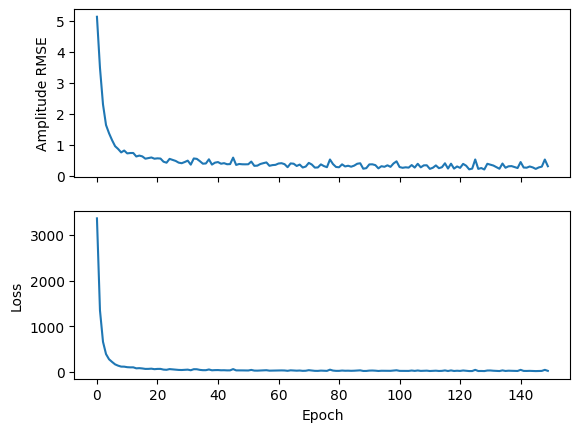

In [9]:
# Plot some training history data
%matplotlib inline 
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(hist_error)
ax1.set_ylabel("Amplitude RMSE")
ax2.plot(hist_loss)
ax2.set_ylabel("Loss")
ax2.set_xlabel("Epoch")
plt.show()